# Preparation

In [1]:
import os
import sys
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from config import CONF
from data.my_data import get_mm_datasets
from models import get_mllm_model
from utils import ModelInspector, log

/home/ubuntu/anaconda3/envs/head/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CONF.root_path

'/home/ubuntu/mzy/AwesomePruning'

In [2]:
# Data prepration
mmsafty = get_mm_datasets('mmsafty')
print(mmsafty.description)

mmsafty_v2 = get_mm_datasets('mmsafty_v2')
print(mmsafty_v2.description)


reject_data = get_mm_datasets('reject_data')
print(reject_data.description)

normal_data = get_mm_datasets('normal_data')
print(normal_data.description)

mmsafty_dl = DataLoader(mmsafty, batch_size=1, shuffle=False)
mmsafty_v2_dl = DataLoader(mmsafty_v2, batch_size=1, shuffle=False)
reject_data_dl = DataLoader(reject_data, batch_size=1, shuffle=False)
normal_data_dl = DataLoader(normal_data, batch_size=1, shuffle=False)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/ubuntu/anaconda3/envs/head/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /home/ubuntu/anaconda3/envs/head/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /home/ubuntu/anaconda3/envs/head/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...
越狱成功的数据，未拒绝回答。
添加了模板字符串，拒绝回答。
越狱失败的数据，拒绝回答。
正常数据，未拒绝回答。


In [3]:
# Model prepration
model, vis_processor = get_mllm_model('minigpt4_llama')
inspector = ModelInspector(model, tokenizer=None, log_path=None)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


trainable params: 33554432 || all params: 6771970048 || trainable%: 0.49548996469513035
Position interpolate from 16x16 to 32x32
Load Minigpt-4-LLM Checkpoint: /home/ubuntu/wwy/MiniGPT_4/weights/minigptv2_checkpoint.pth
[INFO] Log saved in /home/ubuntu/mzy/AwesomePruning/experiments/unruffled_boyd_2025_03_12_10:22:06


# Get target layers / heads

In [13]:
def get_target_name(layer_index, qkvwo='w'):
    """
    Get the target layer name based on the layer index.
    """
    if qkvwo == 'w':
        return f"llama_model.base_model.model.model.layers.{layer_index}.self_attn.save_attn_weight"
    elif qkvwo == 'q':
        return f"llama_model.base_model.model.model.layers.{layer_index}.self_attn.q_proj"
    elif qkvwo == 'k':
        return f"llama_model.base_model.model.model.layers.{layer_index}.self_attn.k_proj"
    elif qkvwo == 'v':
        return f"llama_model.base_model.model.model.layers.{layer_index}.self_attn.v_proj"
    elif qkvwo == 'o':
        return f"llama_model.base_model.model.model.layers.{layer_index}.self_attn.o_proj"
# Safety Layers
target_layers = [13, 9, 3]
target_layer_names = [get_target_name(i) for i in target_layers]
# Safety Heads
target_heads_indices = [4, 9, 8]


# For Normal Inputs

In [ ]:
for inp in normal_data_dl:
    for ii in range(len(target_layer_names)):
        tar_layer_name = target_layer_names[ii]
        tar_head_index = target_heads_indices[ii]
        representations = inspector.get_representation([tar_layer_name], inp, 'generate', num_heads=32)
        # os.makedirs(os.path.join(, 'normal_data'), exist_ok=True)
        # Show Attentions
        inspector.show_attention(inp, representations[tar_layer_name][0], head_indices=tar_head_index, tokenizer=model.llama_tokenizer, is_multimodal=True, image_first=True, image_size=(448, 448), patch_size=14, merged_patch_count=4, cmap='viridis', alpha=0.7, figsize=None, output_path='./attention_visualization.png')

# representations = inspector.get_representation(target_layer_names, template_input, 'generate', num_heads=32)

# Show Attentions

In [11]:
representations


{'meta': {'inputs': {'max_new_tokens': 20,
   'images': tensor([[[[ 0.2515,  0.2953,  0.2953,  ...,  0.9084,  0.8792,  1.0544],
             [ 0.4121,  0.4413,  0.6019,  ...,  1.0982,  0.9230,  0.8792],
             [ 0.3829,  0.1931,  0.4413,  ...,  0.5143,  0.7041,  0.6019],
             ...,
             [-0.6974, -0.6828, -0.8142,  ..., -0.8142, -0.7558, -0.9602],
             [-0.6536, -0.6828, -0.7120,  ..., -0.7558, -0.7850, -0.9893],
             [-0.6098, -0.4638, -0.3178,  ..., -0.8434, -0.7996, -1.0039]],
   
            [[ 0.6792,  0.7692,  0.7092,  ...,  0.4691,  0.4841,  0.7092],
             [ 0.7692,  0.7092,  0.8893,  ...,  0.6792,  0.5141,  0.5141],
             [ 0.8292,  0.5591,  0.7392,  ...,  0.0789,  0.2740,  0.1839],
             ...,
             [-0.7766, -0.7466, -0.8516,  ..., -0.6715, -0.6715, -0.9417],
             [-0.6715, -0.7466, -0.8066,  ..., -0.5965, -0.6715, -0.9717],
             [-0.5965, -0.5215, -0.4614,  ..., -0.6715, -0.6715, -0.9567]],
   
 

总token数: 279, 图像token数: 256
Patch网格大小: 32x32, 每行token数: 8
每4个patch合并为1个token
Token 0: 位置(0,0), 区域(0,0,14,56)
Token 1: 位置(0,1), 区域(0,56,14,112)
Token 2: 位置(0,2), 区域(0,112,14,168)
Token 3: 位置(0,3), 区域(0,168,14,224)
Token 4: 位置(0,4), 区域(0,224,14,280)
Token 5: 位置(0,5), 区域(0,280,14,336)
Token 6: 位置(0,6), 区域(0,336,14,392)
Token 7: 位置(0,7), 区域(0,392,14,448)
Token 8: 位置(1,0), 区域(14,0,28,56)
Token 9: 位置(1,1), 区域(14,56,28,112)
Token 10: 位置(1,2), 区域(14,112,28,168)
Token 11: 位置(1,3), 区域(14,168,28,224)
Token 12: 位置(1,4), 区域(14,224,28,280)
Token 13: 位置(1,5), 区域(14,280,28,336)
Token 14: 位置(1,6), 区域(14,336,28,392)
Token 15: 位置(1,7), 区域(14,392,28,448)
Token 16: 位置(2,0), 区域(28,0,42,56)
Token 17: 位置(2,1), 区域(28,56,42,112)
Token 18: 位置(2,2), 区域(28,112,42,168)
Token 19: 位置(2,3), 区域(28,168,42,224)
Token 20: 位置(2,4), 区域(28,224,42,280)
Token 21: 位置(2,5), 区域(28,280,42,336)
Token 22: 位置(2,6), 区域(28,336,42,392)
Token 23: 位置(2,7), 区域(28,392,42,448)
Token 24: 位置(3,0), 区域(42,0,56,56)
Token 25: 位置(3,1), 区域(42,56,56,

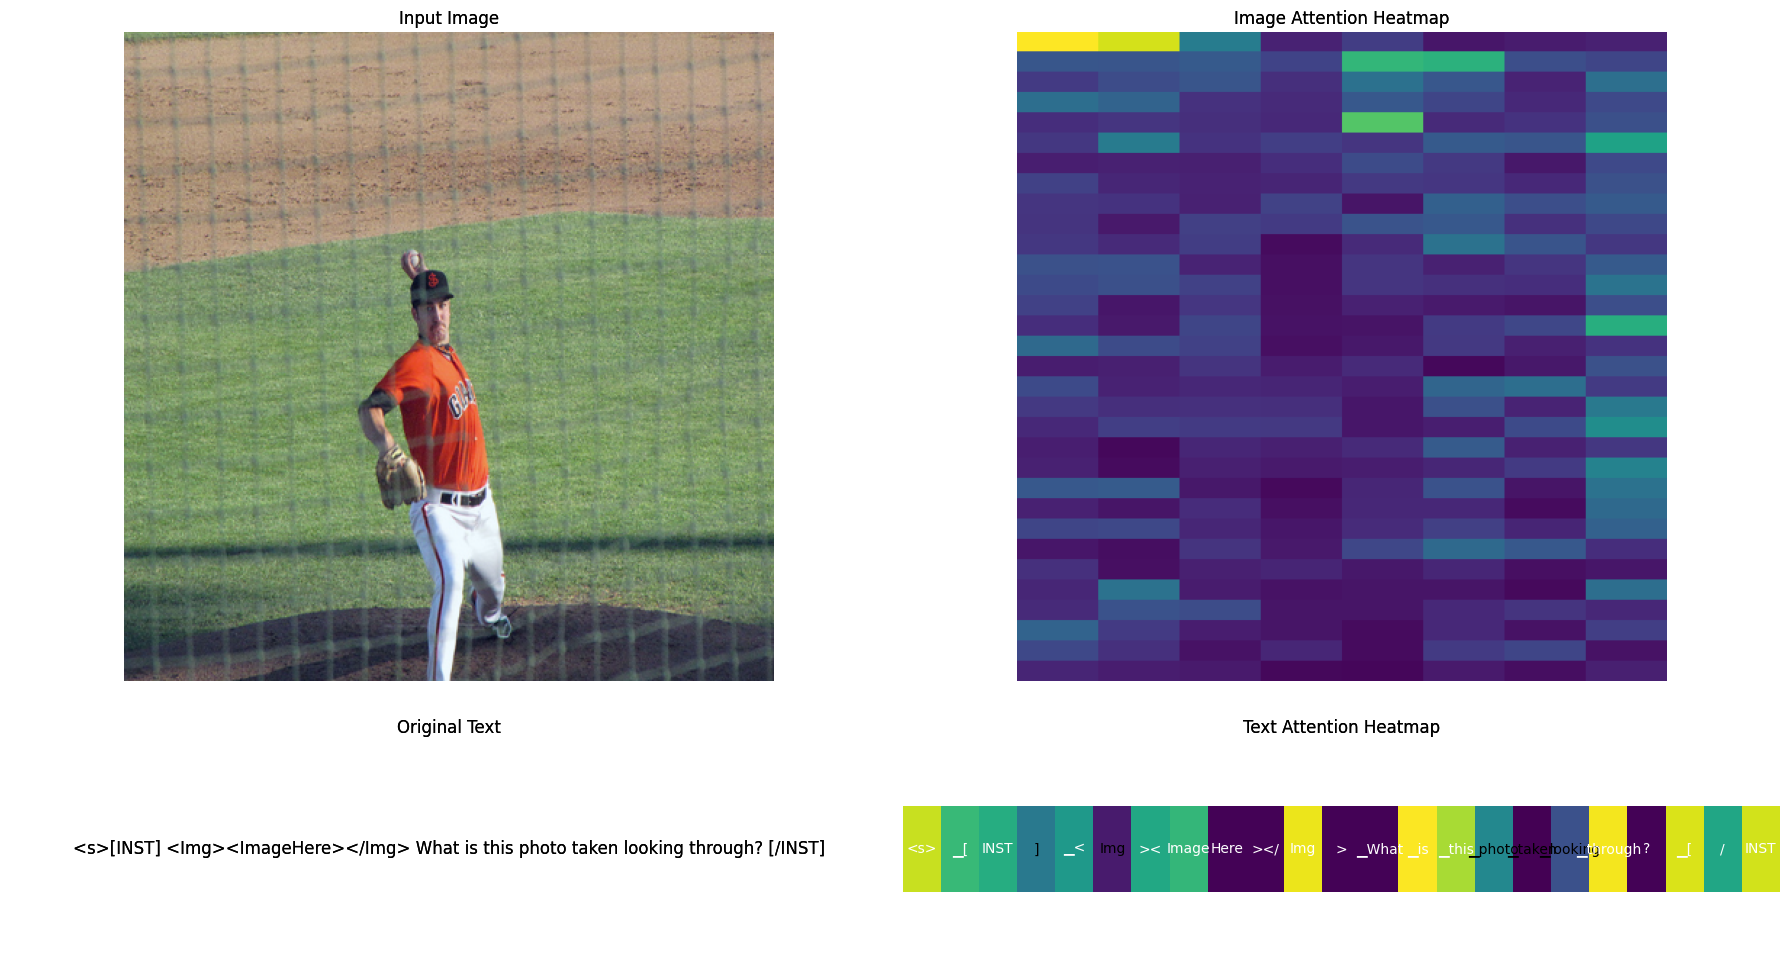

In [12]:
# representations['llama_model.base_model.model.model.layers.13.self_attn.save_attn_weight'][0].shape
# representations['llama_model.base_model.model.model.layers.13.self_attn.save_attn_weight'][1].shape
# representations['llama_model.base_model.model.model.layers.13.self_attn.save_attn_weight'][2].shape
# len(representations['llama_model.base_model.model.model.layers.13.self_attn.save_attn_weight'])
inspector.show_attention(template_input, representations['llama_model.base_model.model.model.layers.13.self_attn.save_attn_weight'][0], head_indices=3, tokenizer=model.llama_tokenizer, is_multimodal=True, image_first=True, image_size=(448, 448), patch_size=14, merged_patch_count=4, cmap='viridis', alpha=0.7, figsize=None, output_path='./attention_visualization.png')
